# bthal dataset v6b pseudobulk DEx tests

    - using DESeq2

1) Run DEGs on HSC/MPP only:

 - healthy CTRL BM_SCR_HSC vs (bthal005 BM_SCR_HSC, bthal006 BM_SCR_HSC, bthal009 BM_SCR_HSC, bthal010 BM_SCR_HSC) (1 list)

2) Run DEGs as before but with only one sample in HD: healthy CTRL.
  
   We ran separate contrasts for the following populations pseudobulked (CD34 + HSC/MPPs)

    - CB45_Zeng_lineages: HSC, MDP, MPP-MkEry, MPP-MyLy, MEP, Ery (6 lists)
    - CB45_Zeng_annots: GMP_Mono, BFU-E, CFU-E (3 lists)
    - CB10_Mende_lineages: HSC/MPP, MDP, late MyP, early MEMBP, late MEMBP, primed MPP (6 lists)
    - CB10_Mende_annots: HSC/MPP3, HSC/MPP1, MPP-to-MEP, MEP1, MEP2, EryP (6 lists)

---
---

In [1]:
library(rjson)

singularity <- fromJSON(file="/.singularity.d/labels.json")
singularity$Version

[1] "proteus.45g"

In [4]:
prefix <- format(as.Date(Sys.time()), "%Y%m%d")
prefix

[1] "20240305"

In [5]:
basedir <- "."

In [7]:
library(anndata)

library(BiocParallel)
library(BiocSingular)

library(scater)
library(scran)
library(DESeq2)
# library(glmGamPoi)

library(Matrix.utils)
library(dplyr)
library(tidyr)
library(ggplot2)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [8]:
register(BPPARAM = MulticoreParam(workers = 4))

---
---

### Read in source data obj
---

In [9]:
ann <- read_h5ad( '20230724_bthalcombo_v6b_lognorm_multi_annotated_scores_galore_clusters.h5ad' )

### Create SCE obj
---

In [12]:
sce <- SingleCellExperiment(
    assays = list(counts = t( as.matrix( ann$layers["counts"] ) ) ), 
    colData = ann$obs[c('donor', 'library', 'xample', 'population', 'condition', 'v6_leiden.20.0_annot_CB10', 'v6_leiden.20.0_annot_CB45', 'lineage.annot', 'lineage.andy')]
)


rownames(sce) <- ann$var_names

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.5 GiB”


**In order to free up memory**

In [13]:
rm( ann )

In [14]:
# Adjusting clusters names in order to reduce issues downstream

dict_replace= c("_" = "-", 
                  "/" = "-",
                  " " = "-")

In [15]:
sce$clusters_nicole <- as.factor( stringr::str_replace_all(string = sce$v6_leiden.20.0_annot_CB10,
                                               pattern = dict_replace) )

sce$lineage_nicole <- as.factor( stringr::str_replace_all(string = sce$lineage.annot,
                                               pattern = dict_replace) )

In [16]:
sce$clusters_andy <- as.factor( stringr::str_replace_all(string = sce$v6_leiden.20.0_annot_CB45,
                                               pattern = dict_replace) )

sce$lineage_andy <- as.factor( stringr::str_replace_all(string = sce$lineage.andy,
                                               pattern = dict_replace) )

---
---

In [17]:
resfolder = paste0("output/dex/DESeq2_pairwise/", prefix, "/")
print(resfolder)

dir.create(resfolder)

[1] "output/dex/DESeq2_pairwise/20240305"


In [18]:
library(tibble)
library(pheatmap)
library(png)
library(RColorBrewer)

### pairwise DEx function
---

In [19]:
# Function to run DESeq2 and get results for all clusters
## x is index of cluster in clusters vector on which to run function
## A is the sample group to compare
## B is the sample group to compare against (base level)

get_dds_resultsAvsB <- function(x, A, B){
    
        print(clusters[x])
    
        cluster_metadata <- metadata[which(metadata$cluster_id == clusters[x]), ]
        rownames(cluster_metadata) <- cluster_metadata$sample_id
        counts <- pb[[clusters[x]]]
    
        cluster_counts <- data.frame(as.matrix(counts)[, which(colnames(counts) %in% rownames(cluster_metadata))])
            
        dds <- DESeqDataSetFromMatrix(cluster_counts, 
                                      colData = cluster_metadata, 
                                      design = ~ group_id)
        
        # Transform counts for data visualization
        rld <- rlog(dds, blind=TRUE)
        
        # Plot PCA        
        DESeq2::plotPCA(rld, intgroup = "group_id")
        ggsave(paste0(resfolder, prefix, "_", basename, "_", clusters[x], "_specific_PCAplot.png"))
               
        # Extract the rlog matrix from the object and compute pairwise correlation values
        rld_mat <- assay(rld)
        rld_cor <- cor(rld_mat)
        
        # Plot heatmap
        png(paste0(resfolder, prefix, "_", basename, "_", clusters[x], "_specific_heatmap.png"))
        pheatmap::pheatmap(rld_cor, annotation = cluster_metadata[, c("group_id"), drop=F])
        dev.off()
        
        # Run DESeq2 differential expression analysis
        dds <- DESeq(dds)
        
        # Plot dispersion estimates
        png(paste0(resfolder, prefix, "_", basename, "_", clusters[x], "_dispersion_plot.png"))
        plotDispEsts(dds)
        dev.off()

        # Output results of Wald test for contrast for A vs B
        contrast <- c("group_id", levels(cluster_metadata$group_id)[A], levels(cluster_metadata$group_id)[B])
        
        # resultsNames(dds)
        res <- results(dds, 
                       contrast = contrast,
                       alpha = 0.05)
    
        write.table(na.exclude( res[order(res$padj, res$pvalue), ] )['stat'], 
                    file = paste0(resfolder, prefix, "_", basename, "_", clusters[x], "_",
                    levels(cluster_metadata$group_id)[A], "_vs_", levels(cluster_metadata$group_id)[B], '.rnk'), 
                    col.names = FALSE, quote = FALSE, sep='\t')    
    
        res <- lfcShrink(dds, 
                         contrast =  contrast,
                         type = "ashr",
                         res=res)
    
        # Set thresholds
        padj_cutoff <- 0.05
        
        # Turn the results object into a tibble for use with tidyverse functions
        res_tbl <- res %>%
                data.frame() %>%
                rownames_to_column(var="gene") %>%
                as_tibble()

        # Write all results to file
        write.table(res_tbl,
                  paste0(resfolder, prefix, "_", basename, "_", clusters[x], "_",
                         levels(cluster_metadata$group_id)[A], "_vs_", levels(cluster_metadata$group_id)[B], 
                         "_all_genes_DESeq2_pb.tsv"),
                  quote = FALSE, 
                  row.names = FALSE,
                  sep='\t')    
        
        # Subset the significant results
        sig_res <- dplyr::filter(res_tbl, padj < padj_cutoff) %>%
                dplyr::arrange(padj)

    
        # Write significant results to file
        write.table(sig_res,
                  paste0(resfolder, prefix, "_", basename, "_", clusters[x], "_",
                         levels(cluster_metadata$group_id)[A], "_vs_", levels(cluster_metadata$group_id)[B],
                         "_sig_genes_DESeq2_pb.tsv"),
                  quote = FALSE, 
                  row.names = FALSE,
                  sep='\t')        
    
        ## ggplot of top genes
        normalized_counts <- counts(dds, 
                                    normalized = TRUE)
        
        ## Order results by padj values
        top20_sig_genes <- sig_res %>%
                dplyr::arrange(padj) %>%
                dplyr::pull(gene) %>%
                head(n=20)
           
        top20_sig_norm <- data.frame(normalized_counts) %>%
                rownames_to_column(var = "gene") %>%
                dplyr::filter(gene %in% top20_sig_genes)
        
        gathered_top20_sig <- top20_sig_norm %>%
                gather(colnames(top20_sig_norm)[2:length(colnames(top20_sig_norm))], key = "samplename", value = "normalized_counts")
        
        gathered_top20_sig <- inner_join(ei[, c("sample_id", "group_id" )], gathered_top20_sig, by = c("sample_id" = "samplename"))
        
        ## plot using ggplot2
        ggplot(gathered_top20_sig) +
                geom_point(aes(x = gene, 
                               y = normalized_counts, 
                               color = group_id), 
                           position=position_jitter(w=0.1,h=0)) +
                scale_y_log10() +
                xlab("Genes") +
                ylab("log10 Normalized Counts") +
                ggtitle("Top 20 Significant DE Genes") +
                theme_bw() +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
                theme(plot.title = element_text(hjust = 0.5))
        ggsave(paste0(resfolder, prefix, "_", basename, "_", clusters[x], "_", levels(cluster_metadata$group_id)[A], "_vs_", levels(cluster_metadata$group_id)[B], "_top20_DE_genes.png"))
}

In [20]:
sce

class: SingleCellExperiment 
dim: 20098 36866 
metadata(0):
assays(1): counts
rownames(20098): RP11-34P13.7 AL627309.1 ... AL354822.1 SRSF10-1
rowData names(0):
colnames(36866): SITTC12_AAACCCATCATACAGC.1.0
  SITTC12_AAACGAAAGCTAGTTC.1.0 ... paedBM2_TTTGTTGGTGTTATCG.1.1
  paedBM2_TTTGTTGTCTGGACCG.1.1
colData names(13): donor library ... clusters_andy lineage_andy
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [22]:
sce_copy <- sce

In [23]:
sce_copy

class: SingleCellExperiment 
dim: 20098 36866 
metadata(0):
assays(1): counts
rownames(20098): RP11-34P13.7 AL627309.1 ... AL354822.1 SRSF10-1
rowData names(0):
colnames(36866): SITTC12_AAACCCATCATACAGC.1.0
  SITTC12_AAACGAAAGCTAGTTC.1.0 ... paedBM2_TTTGTTGGTGTTATCG.1.1
  paedBM2_TTTGTTGTCTGGACCG.1.1
colData names(13): donor library ... clusters_andy lineage_andy
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

### 

### POINT 2)
---

In [24]:
exclude <- c('SLX21505_SITTC7_P185-BM-0', 'SLX21505_SITTE7_P181-BM-0', 'SLX21505_SITTD7_P257-BM-0', 'paedBM1_CD34', 'paedBM2_CD34')

In [32]:
`%nin%` = Negate(`%in%`)

In [34]:
sce <- sce[ , sce@colData$xample %nin% exclude]

In [35]:
dim(sce)

[1] 20098 24185

In [36]:
colData(sce)$group_id <- factor( colData(sce)$condition )

colData(sce)$sample_id <- factor( paste( colData(sce)$condition, colData(sce)$library,   sep = '') )

colData(sce)$donor <- factor( colData(sce)$donor )

## Mende et al (CB10)

### CB10 clusters
---

HSC/MPP3, HSC/MPP1, MPP-to-MEP, MEP1, MEP2, EryP

'v6_leiden.20.0_annot_CB10' / clusters_nicole

In [37]:
unique( sce$clusters_nicole )

[1] 15-MyP4-(GMP)   16-MyP3-(cycle) 05-HSC-MPP3     10-MPP-to-MEP  
 [5] 12-MEP1         13-MEP-cycle    24-MDP          17-EoBasoMCP   
 [9] 09-MyP2         19-HSPC-cycle   00-HSC-MPP2     08-EryP        
[13] 01-LyP2         02-MEP2         06-MyP1         04-HSC-MPP1    
[17] 22-MkP          11-HSC-MPP4    
18 Levels: 00-HSC-MPP2 01-LyP2 02-MEP2 04-HSC-MPP1 05-HSC-MPP3 ... 24-MDP

**Set cluster_id here for ease of code re-use/templating**

In [38]:
sce$cluster_id <- sce$clusters_nicole

In [39]:
basename <- 'bthalcombo_v6b_C10_cluster'

In [40]:
# Named vector of cluster names
kids <- purrr::set_names(levels(sce$cluster_id))
kids

00-HSC-MPP2           01-LyP2           02-MEP2       04-HSC-MPP1 
    "00-HSC-MPP2"         "01-LyP2"         "02-MEP2"     "04-HSC-MPP1" 
      05-HSC-MPP3           06-MyP1           08-EryP           09-MyP2 
    "05-HSC-MPP3"         "06-MyP1"         "08-EryP"         "09-MyP2" 
    10-MPP-to-MEP       11-HSC-MPP4           12-MEP1      13-MEP-cycle 
  "10-MPP-to-MEP"     "11-HSC-MPP4"         "12-MEP1"    "13-MEP-cycle" 
    15-MyP4-(GMP)   16-MyP3-(cycle)      17-EoBasoMCP     19-HSPC-cycle 
  "15-MyP4-(GMP)" "16-MyP3-(cycle)"    "17-EoBasoMCP"   "19-HSPC-cycle" 
           22-MkP            24-MDP 
         "22-MkP"          "24-MDP"

In [41]:
# Total number of clusters
nk <- length(kids)
nk

[1] 18

In [42]:
# Named vector of sample names
sids <- purrr::set_names(levels(sce$sample_id))
sids

bthalSITTA3      bthalSITTB3     bthalSITTC12      bthalSITTC3 
   "bthalSITTA3"    "bthalSITTB3"   "bthalSITTC12"    "bthalSITTC3" 
    bthalSITTD12     bthalSITTE10     bthalSITTF10      bthalSITTG3 
  "bthalSITTD12"   "bthalSITTE10"   "bthalSITTF10"    "bthalSITTG3" 
  healthySITTC10   healthySITTD10 
"healthySITTC10" "healthySITTD10"

In [43]:
# Total number of samples 
ns <- length(sids)
ns

[1] 10

In [44]:
# Generate sample level metadata

## Determine the number of cells per sample
table(sce$sample_id)

## Turn named vector into a numeric vector of number of cells per sample
n_cells <- as.numeric(table(sce$sample_id))

## Determine how to reoder the samples (rows) of the metadata to match the order of sample names in sids vector
m <- match(sids, sce$sample_id)

## Create the sample level metadata by combining the reordered metadata with the number of cells corresponding to each sample.
ei <- data.frame(colData(sce)[m, ], 
                  n_cells, row.names = NULL) %>% 
                select(-"cluster_id")
ei


   bthalSITTA3    bthalSITTB3   bthalSITTC12    bthalSITTC3   bthalSITTD12 
          3220            331           1970            336            496 
  bthalSITTE10   bthalSITTF10    bthalSITTG3 healthySITTC10 healthySITTD10 
          6663           6452            166           2066           2485 

donor        library xample                  population   condition
1  bthal007     SITTA3  bthal007_BM_scr_CD34    CD34         bthal    
2  bthal008     SITTB3  bthal008_BM_scr_CD34    CD34         bthal    
3  bthal005     SITTC12 bthal005_BM_scr_CD34    CD34         bthal    
4  bthal007     SITTC3  bthal007_BM_scr_CD38neg CD34_CD38neg bthal    
5  bthal006     SITTD12 bthal006_BM_scr_CD34    CD34         bthal    
6  bthal010     SITTE10 bthal010_BM_scr_HSC     HSCMPP       bthal    
7  bthal009     SITTF10 bthal009_BM_scr_HSC     HSCMPP       bthal    
8  bthal008     SITTG3  bthal008_BM_scr_CD34    CD34         bthal    
9  healthy_CTRL SITTC10 healthy_CTRL_HSC        HSCMPP       healthy  
10 healthy_CTRL SITTD10 healthy_CTRL_CD34       CD34         healthy  
   v6_leiden.20.0_annot_CB10 v6_leiden.20.0_annot_CB45 lineage.annot
1  19_HSPC cycle             Pro-B Cycling             EryP/MyP mix 
2  15_MyP4 (GMP)             GMP-Mono                  late MyP     
3  15_MyP4 (GMP)             GMP-Mono                  late MyP     
4  09_MyP2                   Early GMP                 early MyP    
5  05_HSC/MPP3               HSC                       HSC/MPP      
6  00_HSC/MPP2               HSC                       HSC/MPP      
7  04_HSC/MPP1               HSC                       HSC/MPP      
8  09_MyP2                   Early GMP                 early MyP    
9  05_HSC/MPP3               MPP-MkEry                 HSC/MPP      
10 09_MyP2                   Early GMP                 early MyP    
   lineage.andy    clusters_nicole lineage_nicole clusters_andy lineage_andy   
1  Bcell Precursor 19-HSPC-cycle   EryP-MyP-mix   Pro-B-Cycling Bcell-Precursor
2  GMP             15-MyP4-(GMP)   late-MyP       GMP-Mono      GMP            
3  GMP             15-MyP4-(GMP)   late-MyP       GMP-Mono      GMP            
4  GMP             09-MyP2         early-MyP      Early-GMP     GMP            
5  HSC             05-HSC-MPP3     HSC-MPP        HSC           HSC            
6  HSC             00-HSC-MPP2     HSC-MPP        HSC           HSC            
7  HSC             04-HSC-MPP1     HSC-MPP        HSC           HSC            
8  GMP             09-MyP2         early-MyP      Early-GMP     GMP            
9  MPP-MkEry       05-HSC-MPP3     HSC-MPP        MPP-MkEry     MPP-MkEry      
10 GMP             09-MyP2         early-MyP      Early-GMP     GMP            
   group_id sample_id      n_cells
1  bthal    bthalSITTA3    3220   
2  bthal    bthalSITTB3     331   
3  bthal    bthalSITTC12   1970   
4  bthal    bthalSITTC3     336   
5  bthal    bthalSITTD12    496   
6  bthal    bthalSITTE10   6663   
7  bthal    bthalSITTF10   6452   
8  bthal    bthalSITTG3     166   
9  healthy  healthySITTC10 2066   
10 healthy  healthySITTD10 2485

In [45]:
dim(sce)

[1] 20098 24185

---
---

#### Count aggregation to sample level
---

In [46]:
# Aggregate the counts per sample_id and cluster_id

# Subset metadata to only include the cluster and sample IDs to aggregate across
groups <- colData(sce)[, c("cluster_id", "sample_id")]

# Aggregate across cluster-sample groups
pb <- aggregate.Matrix(t(counts(sce)), 
                       groupings = groups, fun = "sum") 

class(pb)

dim(pb)

# pb[1:6, 1:6]

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1]   164 20098

In [48]:
# Not every cluster is present in all samples; create a vector that represents how to split samples
splitf <- sapply(stringr::str_split(rownames(pb), 
                                    pattern = "_",
                                    n = 2
                                    ), 
                 `[`, 1)

In [49]:
# Turn into a list and split the list into components for each cluster and transform, so rows are genes and columns are samples and make rownames as the sample IDs
pb <- split.data.frame(pb, 
                       factor(splitf)) %>%
        lapply(function(u) 
                magrittr::set_colnames(t(u), 
                             stringr::str_extract(rownames(u), "(?<=_)[:alnum:]+")))

class(pb)

# Explore the different components of list
# str(pb)

[1] "list"

In [50]:
# Print out the table of cells in each cluster-sample group
options(width = 100)
table(sce$cluster_id, sce$sample_id)

                 
                  bthalSITTA3 bthalSITTB3 bthalSITTC12 bthalSITTC3 bthalSITTD12 bthalSITTE10
  00-HSC-MPP2              52           4           54          17           11          204
  01-LyP2                 130          20           45           0            5          105
  02-MEP2                  33           4           63           1            5           54
  04-HSC-MPP1             217           5           43          59           48          645
  05-HSC-MPP3             904         125          322         179          222         2783
  06-MyP1                 325          60           70          26           41          469
  08-EryP                 159          11          189           0           17           75
  09-MyP2                 139           9           88          10           28          426
  10-MPP-to-MEP            52           7           56           9           13          143
  11-HSC-MPP4               1           0           

In [51]:
# Get sample names for each of the cell type clusters

# prep. data.frame for plotting
get_sample_ids <- function(x){
        pb[[x]] %>%
                colnames()
}

de_samples <- purrr::map(1:length(kids), get_sample_ids) %>%
        unlist()

In [52]:
# Get cluster IDs for each of the samples

samples_list <- purrr::map(1:length(kids), get_sample_ids)

get_cluster_ids <- function(x){
        rep(names(pb)[x], 
            each = length(samples_list[[x]]))
}

de_cluster_ids <- purrr::map(1:length(kids), get_cluster_ids) %>%
        unlist()

In [53]:
# Create a data frame with the sample IDs, cluster IDs and condition

gg_df <- data.frame(cluster_id = de_cluster_ids,
                    sample_id = de_samples)

gg_df <- left_join(gg_df, ei[, c("sample_id", "group_id")]) 


metadata <- gg_df %>%
        dplyr::select(cluster_id, sample_id, group_id) 
        
head(metadata)

Joining with `by = join_by(sample_id)`


cluster_id  sample_id    group_id
1 00-HSC-MPP2 bthalSITTA3  bthal   
2 00-HSC-MPP2 bthalSITTB3  bthal   
3 00-HSC-MPP2 bthalSITTC12 bthal   
4 00-HSC-MPP2 bthalSITTC3  bthal   
5 00-HSC-MPP2 bthalSITTD12 bthal   
6 00-HSC-MPP2 bthalSITTE10 bthal

In [54]:
# Generate vector of cluster IDs
clusters <- levels(as.factor(metadata$cluster_id))
clusters

[1] "00-HSC-MPP2"     "01-LyP2"         "02-MEP2"         "04-HSC-MPP1"     "05-HSC-MPP3"    
 [6] "06-MyP1"         "08-EryP"         "09-MyP2"         "10-MPP-to-MEP"   "11-HSC-MPP4"    
[11] "12-MEP1"         "13-MEP-cycle"    "15-MyP4-(GMP)"   "16-MyP3-(cycle)" "17-EoBasoMCP"   
[16] "19-HSPC-cycle"   "22-MkP"          "24-MDP"

---

In [55]:
type(clusters)

[1] "character"

In [56]:
clusters <- c('02-MEP2', '04-HSC-MPP1', '05-HSC-MPP3','08-EryP','10-MPP-to-MEP','12-MEP1')

In [57]:
clusters

[1] "02-MEP2"       "04-HSC-MPP1"   "05-HSC-MPP3"   "08-EryP"       "10-MPP-to-MEP" "12-MEP1"

#### Run DEx comparisons
---

In [62]:
Sys.time()

# Run the script on all clusters comparing bthal condition relative to healthy condition
purrr::map(1:length(clusters), get_dds_resultsAvsB, A = 1, B = 2)

Sys.time()

[1] "2024-03-05 11:06:47 GMT"

[1] "02-MEP2"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 92 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "04-HSC-MPP1"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 30 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "05-HSC-MPP3"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 68 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "08-EryP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2826 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "10-MPP-to-MEP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 10 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "12-MEP1"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 602 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[[1]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_cluster_02-MEP2_bthal_vs_healthy_top20_DE_genes.png"

[[2]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_cluster_04-HSC-MPP1_bthal_vs_healthy_top20_DE_genes.png"

[[3]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_cluster_05-HSC-MPP3_bthal_vs_healthy_top20_DE_genes.png"

[[4]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_cluster_08-EryP_bthal_vs_healthy_top20_DE_genes.png"

[[5]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_cluster_10-MPP-to-MEP_bthal_vs_healthy_top20_DE_genes.png"

[[6]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_cluster_12-MEP1_bthal_vs_healthy_top20_DE_genes.png"

[1] "2024-03-05 11:08:01 GMT"

### CB10 lineages
---

HSC/MPP, MDP, late MyP, early MEMBP, late MEMBP, primed MPP (6 lists)

In [63]:
unique( colData(sce)$lineage_nicole )

[1] late-MyP     HSC-MPP      primed-MPP   early-MEMBP  late-MEMBP   MDP          early-MyP   
[8] EryP-MyP-mix LyP         
Levels: EryP-MyP-mix HSC-MPP LyP MDP early-MEMBP early-MyP late-MEMBP late-MyP primed-MPP

**Set cluster_id here for ease of code re-use/templating**

In [64]:
sce$cluster_id <- sce$lineage_nicole

In [65]:
basename <- 'bthalcombo_v6b_C10_lineage'

---
---

In [66]:
# Named vector of cluster names
kids <- purrr::set_names(levels(sce$cluster_id))
kids

EryP-MyP-mix        HSC-MPP            LyP            MDP    early-MEMBP      early-MyP 
"EryP-MyP-mix"      "HSC-MPP"          "LyP"          "MDP"  "early-MEMBP"    "early-MyP" 
    late-MEMBP       late-MyP     primed-MPP 
  "late-MEMBP"     "late-MyP"   "primed-MPP"

In [67]:
# Total number of clusters
nk <- length(kids)
nk

[1] 9

In [68]:
# Named vector of sample names
sids <- purrr::set_names(levels(sce$sample_id))
sids

bthalSITTA3      bthalSITTB3     bthalSITTC12      bthalSITTC3     bthalSITTD12 
   "bthalSITTA3"    "bthalSITTB3"   "bthalSITTC12"    "bthalSITTC3"   "bthalSITTD12" 
    bthalSITTE10     bthalSITTF10      bthalSITTG3   healthySITTC10   healthySITTD10 
  "bthalSITTE10"   "bthalSITTF10"    "bthalSITTG3" "healthySITTC10" "healthySITTD10"

In [69]:
# Total number of samples 
ns <- length(sids)
ns

[1] 10

In [70]:
# Generate sample level metadata

## Determine the number of cells per sample
table(sce$sample_id)

## Turn named vector into a numeric vector of number of cells per sample
n_cells <- as.numeric(table(sce$sample_id))

## Determine how to reoder the samples (rows) of the metadata to match the order of sample names in sids vector
m <- match(sids, sce$sample_id)

## Create the sample level metadata by combining the reordered metadata with the number of cells corresponding to each sample.
ei <- data.frame(colData(sce)[m, ], 
                  n_cells, row.names = NULL) %>% 
                select(-"cluster_id")
ei


   bthalSITTA3    bthalSITTB3   bthalSITTC12    bthalSITTC3   bthalSITTD12   bthalSITTE10 
          3220            331           1970            336            496           6663 
  bthalSITTF10    bthalSITTG3 healthySITTC10 healthySITTD10 
          6452            166           2066           2485 

donor        library xample                  population   condition v6_leiden.20.0_annot_CB10
1  bthal007     SITTA3  bthal007_BM_scr_CD34    CD34         bthal     19_HSPC cycle            
2  bthal008     SITTB3  bthal008_BM_scr_CD34    CD34         bthal     15_MyP4 (GMP)            
3  bthal005     SITTC12 bthal005_BM_scr_CD34    CD34         bthal     15_MyP4 (GMP)            
4  bthal007     SITTC3  bthal007_BM_scr_CD38neg CD34_CD38neg bthal     09_MyP2                  
5  bthal006     SITTD12 bthal006_BM_scr_CD34    CD34         bthal     05_HSC/MPP3              
6  bthal010     SITTE10 bthal010_BM_scr_HSC     HSCMPP       bthal     00_HSC/MPP2              
7  bthal009     SITTF10 bthal009_BM_scr_HSC     HSCMPP       bthal     04_HSC/MPP1              
8  bthal008     SITTG3  bthal008_BM_scr_CD34    CD34         bthal     09_MyP2                  
9  healthy_CTRL SITTC10 healthy_CTRL_HSC        HSCMPP       healthy   05_HSC/MPP3              
10 healthy_CTRL SITTD10 healthy_CTRL_CD34       CD34         healthy   09_MyP2                  
   v6_leiden.20.0_annot_CB45 lineage.annot lineage.andy    clusters_nicole lineage_nicole
1  Pro-B Cycling             EryP/MyP mix  Bcell Precursor 19-HSPC-cycle   EryP-MyP-mix  
2  GMP-Mono                  late MyP      GMP             15-MyP4-(GMP)   late-MyP      
3  GMP-Mono                  late MyP      GMP             15-MyP4-(GMP)   late-MyP      
4  Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
5  HSC                       HSC/MPP       HSC             05-HSC-MPP3     HSC-MPP       
6  HSC                       HSC/MPP       HSC             00-HSC-MPP2     HSC-MPP       
7  HSC                       HSC/MPP       HSC             04-HSC-MPP1     HSC-MPP       
8  Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
9  MPP-MkEry                 HSC/MPP       MPP-MkEry       05-HSC-MPP3     HSC-MPP       
10 Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
   clusters_andy lineage_andy    group_id sample_id      n_cells
1  Pro-B-Cycling Bcell-Precursor bthal    bthalSITTA3    3220   
2  GMP-Mono      GMP             bthal    bthalSITTB3     331   
3  GMP-Mono      GMP             bthal    bthalSITTC12   1970   
4  Early-GMP     GMP             bthal    bthalSITTC3     336   
5  HSC           HSC             bthal    bthalSITTD12    496   
6  HSC           HSC             bthal    bthalSITTE10   6663   
7  HSC           HSC             bthal    bthalSITTF10   6452   
8  Early-GMP     GMP             bthal    bthalSITTG3     166   
9  MPP-MkEry     MPP-MkEry       healthy  healthySITTC10 2066   
10 Early-GMP     GMP             healthy  healthySITTD10 2485

In [71]:
dim(sce)

[1] 20098 24185

---
---

#### Count aggregation to sample level
---

In [72]:
# Aggregate the counts per sample_id and cluster_id

# Subset metadata to only include the cluster and sample IDs to aggregate across
groups <- colData(sce)[, c("cluster_id", "sample_id")]

# Aggregate across cluster-sample groups
pb <- aggregate.Matrix(t(counts(sce)), 
                       groupings = groups, fun = "sum") 

class(pb)

dim(pb)

# pb[1:6, 1:6]

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1]    86 20098

In [73]:
# Not every cluster is present in all samples; create a vector that represents how to split samples
splitf <- sapply(stringr::str_split(rownames(pb), 
                                    pattern = "_",
                                    n = 2
                                    ), 
                 `[`, 1)

In [74]:
# Turn into a list and split the list into components for each cluster and transform, so rows are genes and columns are samples and make rownames as the sample IDs
pb <- split.data.frame(pb, 
                       factor(splitf)) %>%
        lapply(function(u) 
                magrittr::set_colnames(t(u), 
                             stringr::str_extract(rownames(u), "(?<=_)[:alnum:]+")))

class(pb)

# Explore the different components of list
# str(pb)

[1] "list"

In [75]:
# Print out the table of cells in each cluster-sample group
options(width = 100)
table(sce$cluster_id, sce$sample_id)

              
               bthalSITTA3 bthalSITTB3 bthalSITTC12 bthalSITTC3 bthalSITTD12 bthalSITTE10
  EryP-MyP-mix         144          10          108          17           14          190
  HSC-MPP             1174         134          424         255          281         3741
  LyP                  130          20           45           0            5          105
  MDP                   20           1           57           0            3           71
  early-MEMBP           53           5          101           1            9          124
  early-MyP            464          69          158          36           69          895
  late-MEMBP           296          18          441           1           36          234
  late-MyP             887          67          580          17           66         1160
  primed-MPP            52           7           56           9           13          143
              
               bthalSITTF10 bthalSITTG3 healthySITTC10 healthySITTD10


In [76]:
# Get sample names for each of the cell type clusters

# prep. data.frame for plotting
get_sample_ids <- function(x){
        pb[[x]] %>%
                colnames()
}

de_samples <- purrr::map(1:length(kids), get_sample_ids) %>%
        unlist()

In [77]:
# Get cluster IDs for each of the samples

samples_list <- purrr::map(1:length(kids), get_sample_ids)

get_cluster_ids <- function(x){
        rep(names(pb)[x], 
            each = length(samples_list[[x]]))
}

de_cluster_ids <- purrr::map(1:length(kids), get_cluster_ids) %>%
        unlist()

In [78]:
# Create a data frame with the sample IDs, cluster IDs and condition

gg_df <- data.frame(cluster_id = de_cluster_ids,
                    sample_id = de_samples)

gg_df <- left_join(gg_df, ei[, c("sample_id", "group_id")]) 


metadata <- gg_df %>%
        dplyr::select(cluster_id, sample_id, group_id) 
        
head( metadata )

Joining with `by = join_by(sample_id)`


cluster_id   sample_id    group_id
1 EryP-MyP-mix bthalSITTA3  bthal   
2 EryP-MyP-mix bthalSITTB3  bthal   
3 EryP-MyP-mix bthalSITTC12 bthal   
4 EryP-MyP-mix bthalSITTC3  bthal   
5 EryP-MyP-mix bthalSITTD12 bthal   
6 EryP-MyP-mix bthalSITTE10 bthal

In [79]:
# Generate vector of cluster IDs
clusters <- levels(as.factor(metadata$cluster_id))
clusters

[1] "EryP-MyP-mix" "HSC-MPP"      "LyP"          "MDP"          "early-MEMBP"  "early-MyP"   
[7] "late-MEMBP"   "late-MyP"     "primed-MPP"

---

In [80]:
clusters <- c('HSC-MPP', 'primed-MPP', 'early-MEMBP', 'late-MEMBP', 'MDP', 'late-MyP')

In [81]:
clusters

[1] "HSC-MPP"     "primed-MPP"  "early-MEMBP" "late-MEMBP"  "MDP"         "late-MyP"

#### Run DEx comparisons
---

In [82]:
Sys.time()

# Run the script on all clusters comparing bthal condition relative to healthy condition
purrr::map(1:length(clusters), get_dds_resultsAvsB, A = 1, B = 2)

Sys.time()

[1] "2024-03-05 11:27:53 GMT"

[1] "HSC-MPP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 79 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "primed-MPP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 10 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "early-MEMBP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 299 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "late-MEMBP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1423 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "MDP"


converting counts to integer mode

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image


[1] "late-MyP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 552 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[[1]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_lineage_HSC-MPP_bthal_vs_healthy_top20_DE_genes.png"

[[2]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_lineage_primed-MPP_bthal_vs_healthy_top20_DE_genes.png"

[[3]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_lineage_early-MEMBP_bthal_vs_healthy_top20_DE_genes.png"

[[4]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_lineage_late-MEMBP_bthal_vs_healthy_top20_DE_genes.png"

[[5]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_lineage_MDP_bthal_vs_healthy_top20_DE_genes.png"

[[6]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C10_lineage_late-MyP_bthal_vs_healthy_top20_DE_genes.png"

[1] "2024-03-05 11:29:05 GMT"

## 

## Zeng et al (CB45)

Differential gene expression bthal vs healthy:

- Combo45_Andy_clusters: GMP_Mono, BFU-E, CFU-E (3 lists)
- Combo45_Andy_lineages: HSC, MDP, MPP-MkEry, MPP-MyLy, MEP, Ery (6 lists)


### CB45 clusters
---

GMP_Mono, BFU-E, CFU-E (3 lists)

In [83]:
unique( colData(sce)$clusters_andy )

[1] GMP-Mono                Pro-B-VDJ               HSC                     MPP-MkEry              
 [5] Pre-cDC                 Early-GMP               CFU-E                   Pro-Erythroblast       
 [9] GMP-Neut                Cycling-Progenitor      pDC                     Large-Pre-B            
[13] LMPP                    BFU-E                   MPP-MyLy                CLP                    
[17] Pre-pDC                 MEP                     GMP-Cycle               EoBasoMast-Precursor   
[21] Megakaryocyte-Precursor Pre-ProB                MLP                     Pro-B-Cycling          
[25] Early-ProMono           Pre-pDC-Cycling         Basophilic-Erythroblast MLP-II                 
28 Levels: BFU-E Basophilic-Erythroblast CFU-E CLP Cycling-Progenitor Early-GMP ... pDC

**Set cluster_id here for ease of code re-use/templating**

In [84]:
sce$cluster_id <- sce$clusters_andy

In [85]:
basename <- 'bthalcombo_v6b_C45_cluster'

---
---

In [86]:
# Named vector of cluster names
kids <- purrr::set_names(levels(sce$cluster_id))
kids

BFU-E   Basophilic-Erythroblast                     CFU-E 
                  "BFU-E" "Basophilic-Erythroblast"                   "CFU-E" 
                      CLP        Cycling-Progenitor                 Early-GMP 
                    "CLP"      "Cycling-Progenitor"               "Early-GMP" 
            Early-ProMono      EoBasoMast-Precursor                 GMP-Cycle 
          "Early-ProMono"    "EoBasoMast-Precursor"               "GMP-Cycle" 
                 GMP-Mono                  GMP-Neut                       HSC 
               "GMP-Mono"                "GMP-Neut"                     "HSC" 
                     LMPP               Large-Pre-B                       MEP 
                   "LMPP"             "Large-Pre-B"                     "MEP" 
                      MLP                    MLP-II                 MPP-MkEry 
                    "MLP"                  "MLP-II"               "MPP-MkEry" 
                 MPP-MyLy   Megakaryocyte-Precursor                  Pre-ProB 
               "MPP-MyLy" "Megakaryocyte-Precursor"                "Pre-ProB" 
                  Pre-cDC                   Pre-pDC           Pre-pDC-Cycling 
                "Pre-cDC"                 "Pre-pDC"         "Pre-pDC-Cycling" 
            Pro-B-Cycling                 Pro-B-VDJ          Pro-Erythroblast 
          "Pro-B-Cycling"               "Pro-B-VDJ"        "Pro-Erythroblast" 
                      pDC 
                    "pDC"

In [87]:
# Total number of clusters
nk <- length(kids)
nk

[1] 28

In [88]:
# Named vector of sample names
sids <- purrr::set_names(levels(sce$sample_id))
sids

bthalSITTA3      bthalSITTB3     bthalSITTC12      bthalSITTC3     bthalSITTD12 
   "bthalSITTA3"    "bthalSITTB3"   "bthalSITTC12"    "bthalSITTC3"   "bthalSITTD12" 
    bthalSITTE10     bthalSITTF10      bthalSITTG3   healthySITTC10   healthySITTD10 
  "bthalSITTE10"   "bthalSITTF10"    "bthalSITTG3" "healthySITTC10" "healthySITTD10"

In [89]:
# Total number of samples 
ns <- length(sids)
ns

[1] 10

In [90]:
# Generate sample level metadata

## Determine the number of cells per sample
table(sce$sample_id)

## Turn named vector into a numeric vector of number of cells per sample
n_cells <- as.numeric(table(sce$sample_id))

## Determine how to reoder the samples (rows) of the metadata to match the order of sample names in sids vector
m <- match(sids, sce$sample_id)

## Create the sample level metadata by combining the reordered metadata with the number of cells corresponding to each sample.
ei <- data.frame(colData(sce)[m, ], 
                  n_cells, row.names = NULL) %>% 
                select(-"cluster_id")
ei


   bthalSITTA3    bthalSITTB3   bthalSITTC12    bthalSITTC3   bthalSITTD12   bthalSITTE10 
          3220            331           1970            336            496           6663 
  bthalSITTF10    bthalSITTG3 healthySITTC10 healthySITTD10 
          6452            166           2066           2485 

donor        library xample                  population   condition v6_leiden.20.0_annot_CB10
1  bthal007     SITTA3  bthal007_BM_scr_CD34    CD34         bthal     19_HSPC cycle            
2  bthal008     SITTB3  bthal008_BM_scr_CD34    CD34         bthal     15_MyP4 (GMP)            
3  bthal005     SITTC12 bthal005_BM_scr_CD34    CD34         bthal     15_MyP4 (GMP)            
4  bthal007     SITTC3  bthal007_BM_scr_CD38neg CD34_CD38neg bthal     09_MyP2                  
5  bthal006     SITTD12 bthal006_BM_scr_CD34    CD34         bthal     05_HSC/MPP3              
6  bthal010     SITTE10 bthal010_BM_scr_HSC     HSCMPP       bthal     00_HSC/MPP2              
7  bthal009     SITTF10 bthal009_BM_scr_HSC     HSCMPP       bthal     04_HSC/MPP1              
8  bthal008     SITTG3  bthal008_BM_scr_CD34    CD34         bthal     09_MyP2                  
9  healthy_CTRL SITTC10 healthy_CTRL_HSC        HSCMPP       healthy   05_HSC/MPP3              
10 healthy_CTRL SITTD10 healthy_CTRL_CD34       CD34         healthy   09_MyP2                  
   v6_leiden.20.0_annot_CB45 lineage.annot lineage.andy    clusters_nicole lineage_nicole
1  Pro-B Cycling             EryP/MyP mix  Bcell Precursor 19-HSPC-cycle   EryP-MyP-mix  
2  GMP-Mono                  late MyP      GMP             15-MyP4-(GMP)   late-MyP      
3  GMP-Mono                  late MyP      GMP             15-MyP4-(GMP)   late-MyP      
4  Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
5  HSC                       HSC/MPP       HSC             05-HSC-MPP3     HSC-MPP       
6  HSC                       HSC/MPP       HSC             00-HSC-MPP2     HSC-MPP       
7  HSC                       HSC/MPP       HSC             04-HSC-MPP1     HSC-MPP       
8  Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
9  MPP-MkEry                 HSC/MPP       MPP-MkEry       05-HSC-MPP3     HSC-MPP       
10 Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
   clusters_andy lineage_andy    group_id sample_id      n_cells
1  Pro-B-Cycling Bcell-Precursor bthal    bthalSITTA3    3220   
2  GMP-Mono      GMP             bthal    bthalSITTB3     331   
3  GMP-Mono      GMP             bthal    bthalSITTC12   1970   
4  Early-GMP     GMP             bthal    bthalSITTC3     336   
5  HSC           HSC             bthal    bthalSITTD12    496   
6  HSC           HSC             bthal    bthalSITTE10   6663   
7  HSC           HSC             bthal    bthalSITTF10   6452   
8  Early-GMP     GMP             bthal    bthalSITTG3     166   
9  MPP-MkEry     MPP-MkEry       healthy  healthySITTC10 2066   
10 Early-GMP     GMP             healthy  healthySITTD10 2485

In [91]:
dim(sce)

[1] 20098 24185

---
---

#### Count aggregation to sample level
---

In [92]:
# Aggregate the counts per sample_id and cluster_id

# Subset metadata to only include the cluster and sample IDs to aggregate across
groups <- colData(sce)[, c("cluster_id", "sample_id")]

# Aggregate across cluster-sample groups
pb <- aggregate.Matrix(t(counts(sce)), 
                       groupings = groups, fun = "sum") 

class(pb)

dim(pb)

# pb[1:6, 1:6]

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1]   218 20098

In [93]:
# Not every cluster is present in all samples; create a vector that represents how to split samples
splitf <- sapply(stringr::str_split(rownames(pb), 
                                    pattern = "_",
                                    n = 2
                                    ), 
                 `[`, 1)

In [94]:
# Turn into a list and split the list into components for each cluster and transform, so rows are genes and columns are samples and make rownames as the sample IDs
pb <- split.data.frame(pb, 
                       factor(splitf)) %>%
        lapply(function(u) 
                magrittr::set_colnames(t(u), 
                             stringr::str_extract(rownames(u), "(?<=_)[:alnum:]+")))

class(pb)

# Explore the different components of list
# str(pb)

[1] "list"

In [95]:
# Print out the table of cells in each cluster-sample group
options(width = 100)
table(sce$cluster_id, sce$sample_id)

                         
                          bthalSITTA3 bthalSITTB3 bthalSITTC12 bthalSITTC3 bthalSITTD12
  BFU-E                            75           4          103           0            5
  Basophilic-Erythroblast          21           0           15           0            6
  CFU-E                           106          10          140           0            8
  CLP                               3           0            3           0            0
  Cycling-Progenitor              227           9           93          36           48
  Early-GMP                       219          33          144           6           40
  Early-ProMono                    20           4           27           0            2
  EoBasoMast-Precursor             16           1           27           0            3
  GMP-Cycle                         5           0            7           0            0
  GMP-Mono                         39           7           69           0            6
  GMP-

In [96]:
# Get sample names for each of the cell type clusters

# prep. data.frame for plotting
get_sample_ids <- function(x){
        pb[[x]] %>%
                colnames()
}

de_samples <- purrr::map(1:length(kids), get_sample_ids) %>%
        unlist()

In [97]:
# Get cluster IDs for each of the samples

samples_list <- purrr::map(1:length(kids), get_sample_ids)

get_cluster_ids <- function(x){
        rep(names(pb)[x], 
            each = length(samples_list[[x]]))
}

de_cluster_ids <- purrr::map(1:length(kids), get_cluster_ids) %>%
        unlist()

In [98]:
# Create a data frame with the sample IDs, cluster IDs and condition

gg_df <- data.frame(cluster_id = de_cluster_ids,
                    sample_id = de_samples)

gg_df <- left_join(gg_df, ei[, c("sample_id", "group_id")]) 


metadata <- gg_df %>%
        dplyr::select(cluster_id, sample_id, group_id) 
        
head( metadata )

Joining with `by = join_by(sample_id)`


cluster_id sample_id    group_id
1 BFU-E      bthalSITTA3  bthal   
2 BFU-E      bthalSITTB3  bthal   
3 BFU-E      bthalSITTC12 bthal   
4 BFU-E      bthalSITTD12 bthal   
5 BFU-E      bthalSITTE10 bthal   
6 BFU-E      bthalSITTF10 bthal

In [99]:
# Generate vector of cluster IDs
clusters <- levels(as.factor(metadata$cluster_id))
clusters

[1] "BFU-E"                   "Basophilic-Erythroblast" "CFU-E"                  
 [4] "CLP"                     "Cycling-Progenitor"      "Early-GMP"              
 [7] "Early-ProMono"           "EoBasoMast-Precursor"    "GMP-Cycle"              
[10] "GMP-Mono"                "GMP-Neut"                "HSC"                    
[13] "LMPP"                    "Large-Pre-B"             "MEP"                    
[16] "MLP"                     "MLP-II"                  "MPP-MkEry"              
[19] "MPP-MyLy"                "Megakaryocyte-Precursor" "Pre-ProB"               
[22] "Pre-cDC"                 "Pre-pDC"                 "Pre-pDC-Cycling"        
[25] "Pro-B-Cycling"           "Pro-B-VDJ"               "Pro-Erythroblast"       
[28] "pDC"

---

#### Run DEx comparisons
---

In [100]:
clusters <- c('GMP-Mono', 'BFU-E', 'CFU-E')

In [101]:
Sys.time()

# Run the script on all clusters comparing bthal condition relative to healthy condition
purrr::map(1:length(clusters), get_dds_resultsAvsB, A = 1, B = 2)

Sys.time()

[1] "2024-03-05 11:38:59 GMT"

[1] "GMP-Mono"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2078 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "BFU-E"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 847 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "CFU-E"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2908 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[[1]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_cluster_GMP-Mono_bthal_vs_healthy_top20_DE_genes.png"

[[2]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_cluster_BFU-E_bthal_vs_healthy_top20_DE_genes.png"

[[3]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_cluster_CFU-E_bthal_vs_healthy_top20_DE_genes.png"

[1] "2024-03-05 11:39:36 GMT"

### CB45 lineages
---

HSC, MDP, MPP-MkEry, MPP-MyLy, MEP, Ery (6 lists)

In [102]:
unique( colData(sce)$lineage_andy )

[1] GMP                     Bcell-Precursor         HSC                     MPP-MkEry              
 [5] MDP                     Erytroid                Cycling-Progenitor      MLP                    
 [9] MPP-MyLy                CLP                     MEP                     EoBasoMast-Precursor   
[13] Megakaryocyte-Precursor Mono                   
14 Levels: Bcell-Precursor CLP Cycling-Progenitor EoBasoMast-Precursor Erytroid GMP HSC MDP ... Mono

**Set cluster_id here for ease of code re-use/templating**

In [103]:
sce$cluster_id <- sce$lineage_andy

In [104]:
basename <- 'bthalcombo_v6b_C45_lineage'

---
---

In [105]:
# Named vector of cluster names
kids <- purrr::set_names(levels(sce$cluster_id))
kids

Bcell-Precursor                       CLP        Cycling-Progenitor 
        "Bcell-Precursor"                     "CLP"      "Cycling-Progenitor" 
     EoBasoMast-Precursor                  Erytroid                       GMP 
   "EoBasoMast-Precursor"                "Erytroid"                     "GMP" 
                      HSC                       MDP                       MEP 
                    "HSC"                     "MDP"                     "MEP" 
                      MLP                 MPP-MkEry                  MPP-MyLy 
                    "MLP"               "MPP-MkEry"                "MPP-MyLy" 
  Megakaryocyte-Precursor                      Mono 
"Megakaryocyte-Precursor"                    "Mono"

In [106]:
# Total number of clusters
nk <- length(kids)
nk

[1] 14

In [107]:
# Named vector of sample names
sids <- purrr::set_names(levels(sce$sample_id))
sids

bthalSITTA3      bthalSITTB3     bthalSITTC12      bthalSITTC3     bthalSITTD12 
   "bthalSITTA3"    "bthalSITTB3"   "bthalSITTC12"    "bthalSITTC3"   "bthalSITTD12" 
    bthalSITTE10     bthalSITTF10      bthalSITTG3   healthySITTC10   healthySITTD10 
  "bthalSITTE10"   "bthalSITTF10"    "bthalSITTG3" "healthySITTC10" "healthySITTD10"

In [108]:
# Total number of samples 
ns <- length(sids)
ns

[1] 10

In [109]:
# Generate sample level metadata

## Determine the number of cells per sample
table(sce$sample_id)

## Turn named vector into a numeric vector of number of cells per sample
n_cells <- as.numeric(table(sce$sample_id))

## Determine how to reoder the samples (rows) of the metadata to match the order of sample names in sids vector
m <- match(sids, sce$sample_id)

## Create the sample level metadata by combining the reordered metadata with the number of cells corresponding to each sample.
ei <- data.frame(colData(sce)[m, ], 
                  n_cells, row.names = NULL) %>% 
                select(-"cluster_id")
ei


   bthalSITTA3    bthalSITTB3   bthalSITTC12    bthalSITTC3   bthalSITTD12   bthalSITTE10 
          3220            331           1970            336            496           6663 
  bthalSITTF10    bthalSITTG3 healthySITTC10 healthySITTD10 
          6452            166           2066           2485 

donor        library xample                  population   condition v6_leiden.20.0_annot_CB10
1  bthal007     SITTA3  bthal007_BM_scr_CD34    CD34         bthal     19_HSPC cycle            
2  bthal008     SITTB3  bthal008_BM_scr_CD34    CD34         bthal     15_MyP4 (GMP)            
3  bthal005     SITTC12 bthal005_BM_scr_CD34    CD34         bthal     15_MyP4 (GMP)            
4  bthal007     SITTC3  bthal007_BM_scr_CD38neg CD34_CD38neg bthal     09_MyP2                  
5  bthal006     SITTD12 bthal006_BM_scr_CD34    CD34         bthal     05_HSC/MPP3              
6  bthal010     SITTE10 bthal010_BM_scr_HSC     HSCMPP       bthal     00_HSC/MPP2              
7  bthal009     SITTF10 bthal009_BM_scr_HSC     HSCMPP       bthal     04_HSC/MPP1              
8  bthal008     SITTG3  bthal008_BM_scr_CD34    CD34         bthal     09_MyP2                  
9  healthy_CTRL SITTC10 healthy_CTRL_HSC        HSCMPP       healthy   05_HSC/MPP3              
10 healthy_CTRL SITTD10 healthy_CTRL_CD34       CD34         healthy   09_MyP2                  
   v6_leiden.20.0_annot_CB45 lineage.annot lineage.andy    clusters_nicole lineage_nicole
1  Pro-B Cycling             EryP/MyP mix  Bcell Precursor 19-HSPC-cycle   EryP-MyP-mix  
2  GMP-Mono                  late MyP      GMP             15-MyP4-(GMP)   late-MyP      
3  GMP-Mono                  late MyP      GMP             15-MyP4-(GMP)   late-MyP      
4  Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
5  HSC                       HSC/MPP       HSC             05-HSC-MPP3     HSC-MPP       
6  HSC                       HSC/MPP       HSC             00-HSC-MPP2     HSC-MPP       
7  HSC                       HSC/MPP       HSC             04-HSC-MPP1     HSC-MPP       
8  Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
9  MPP-MkEry                 HSC/MPP       MPP-MkEry       05-HSC-MPP3     HSC-MPP       
10 Early GMP                 early MyP     GMP             09-MyP2         early-MyP     
   clusters_andy lineage_andy    group_id sample_id      n_cells
1  Pro-B-Cycling Bcell-Precursor bthal    bthalSITTA3    3220   
2  GMP-Mono      GMP             bthal    bthalSITTB3     331   
3  GMP-Mono      GMP             bthal    bthalSITTC12   1970   
4  Early-GMP     GMP             bthal    bthalSITTC3     336   
5  HSC           HSC             bthal    bthalSITTD12    496   
6  HSC           HSC             bthal    bthalSITTE10   6663   
7  HSC           HSC             bthal    bthalSITTF10   6452   
8  Early-GMP     GMP             bthal    bthalSITTG3     166   
9  MPP-MkEry     MPP-MkEry       healthy  healthySITTC10 2066   
10 Early-GMP     GMP             healthy  healthySITTD10 2485

In [110]:
dim(sce)

[1] 20098 24185

---
---

#### Count aggregation to sample level
---

In [111]:
# Aggregate the counts per sample_id and cluster_id

# Subset metadata to only include the cluster and sample IDs to aggregate across
groups <- colData(sce)[, c("cluster_id", "sample_id")]

# Aggregate across cluster-sample groups
pb <- aggregate.Matrix(t(counts(sce)), 
                       groupings = groups, fun = "sum") 

class(pb)

dim(pb)

# pb[1:6, 1:6]

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1]   126 20098

In [112]:
# Not every cluster is present in all samples; create a vector that represents how to split samples
splitf <- sapply(stringr::str_split(rownames(pb), 
                                    pattern = "_",
                                    n = 2
                                    ), 
                 `[`, 1)

In [113]:
# Turn into a list and split the list into components for each cluster and transform, so rows are genes and columns are samples and make rownames as the sample IDs
pb <- split.data.frame(pb, 
                       factor(splitf)) %>%
        lapply(function(u) 
                magrittr::set_colnames(t(u), 
                             stringr::str_extract(rownames(u), "(?<=_)[:alnum:]+")))

# class(pb)

# Explore the different components of list
# str(pb)

In [114]:
# Print out the table of cells in each cluster-sample group
options(width = 100)
table(sce$cluster_id, sce$sample_id)

                         
                          bthalSITTA3 bthalSITTB3 bthalSITTC12 bthalSITTC3 bthalSITTD12
  Bcell-Precursor                 793          34          280           0           16
  CLP                               3           0            3           0            0
  Cycling-Progenitor              227           9           93          36           48
  EoBasoMast-Precursor             16           1           27           0            3
  Erytroid                        263          14          408           1           24
  GMP                             337          51          299           6           52
  HSC                             765          94          236         192          194
  MDP                              51          10          144           0            7
  MEP                              49           7          115           2            8
  MLP                             253           7          109          31           53
  MPP-

In [115]:
# Get sample names for each of the cell type clusters

# prep. data.frame for plotting
get_sample_ids <- function(x){
        pb[[x]] %>%
                colnames()
}

de_samples <- purrr::map(1:length(kids), get_sample_ids) %>%
        unlist()

In [116]:
# Get cluster IDs for each of the samples

samples_list <- purrr::map(1:length(kids), get_sample_ids)

get_cluster_ids <- function(x){
        rep(names(pb)[x], 
            each = length(samples_list[[x]]))
}

de_cluster_ids <- purrr::map(1:length(kids), get_cluster_ids) %>%
        unlist()

In [117]:
# Create a data frame with the sample IDs, cluster IDs and condition

gg_df <- data.frame(cluster_id = de_cluster_ids,
                    sample_id = de_samples)

gg_df <- left_join(gg_df, ei[, c("sample_id", "group_id")]) 


metadata <- gg_df %>%
        dplyr::select(cluster_id, sample_id, group_id) 
        
head( metadata )

Joining with `by = join_by(sample_id)`


cluster_id      sample_id    group_id
1 Bcell-Precursor bthalSITTA3  bthal   
2 Bcell-Precursor bthalSITTB3  bthal   
3 Bcell-Precursor bthalSITTC12 bthal   
4 Bcell-Precursor bthalSITTD12 bthal   
5 Bcell-Precursor bthalSITTE10 bthal   
6 Bcell-Precursor bthalSITTF10 bthal

In [118]:
# Generate vector of cluster IDs
clusters <- levels(as.factor(metadata$cluster_id))
clusters

[1] "Bcell-Precursor"         "CLP"                     "Cycling-Progenitor"     
 [4] "EoBasoMast-Precursor"    "Erytroid"                "GMP"                    
 [7] "HSC"                     "MDP"                     "MEP"                    
[10] "MLP"                     "MPP-MkEry"               "MPP-MyLy"               
[13] "Megakaryocyte-Precursor" "Mono"

---

#### Run DEx comparisons
---

In [119]:
clusters <- c('HSC', 'MPP-MkEry', 'MPP-MyLy', 'MEP', 'Erytroid', 'MDP' )

In [120]:
Sys.time()

# Run the script on all clusters comparing bthal condition relative to healthy condition
purrr::map(1:length(clusters), get_dds_resultsAvsB, A = 1, B = 2)

Sys.time()

[1] "2024-03-05 11:44:18 GMT"

[1] "HSC"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 48 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "MPP-MkEry"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 21 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "MPP-MyLy"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 31 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "MEP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 11 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "Erytroid"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2106 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "MDP"


converting counts to integer mode

using ntop=500 top features by variance

Saving 6.67 x 6.67 in image
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2074 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”


[[1]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_lineage_HSC_bthal_vs_healthy_top20_DE_genes.png"

[[2]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_lineage_MPP-MkEry_bthal_vs_healthy_top20_DE_genes.png"

[[3]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_lineage_MPP-MyLy_bthal_vs_healthy_top20_DE_genes.png"

[[4]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_lineage_MEP_bthal_vs_healthy_top20_DE_genes.png"

[[5]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_lineage_Erytroid_bthal_vs_healthy_top20_DE_genes.png"

[[6]]
[1] "output/dex/DESeq2_pairwise/20240305/20240305_bthalcombo_v6b_C45_lineage_MDP_bthal_vs_healthy_top20_DE_genes.png"

[1] "2024-03-05 11:45:28 GMT"

## POINT 1)
---

In [121]:
hsc <- c('healthy_CTRL_HSC', 'bthal005_BM_scr_HSC', 'bthal006_BM_scr_HSC', 'bthal009_BM_scr_HSC', 'bthal010_BM_scr_HSC')

In [122]:
sce <- sce_copy[ , sce_copy@colData$xample %in% hsc]

In [123]:
dim(sce)

[1] 20098  8782

In [124]:
dim(sce)[2]

[1] 8782

#### Make some arbitrary pseudo-replicates

In [125]:
sce@colData$replicate <- sample(c('rep1', 'rep2', 'rep3', 'rep4'),
                               prob=c(0.25, 0.25, 0.25, 0.25),
                               size=dim(sce)[2],
                               replace=TRUE)

colData(sce)$replicate <- factor( colData(sce)$replicate )

In [126]:
as.data.frame(sce@colData) %>% count(xample, replicate)

xample              replicate n  
1  bthal005_BM_scr_HSC rep1       11
2  bthal005_BM_scr_HSC rep2       19
3  bthal005_BM_scr_HSC rep3       14
4  bthal005_BM_scr_HSC rep4       12
5  bthal006_BM_scr_HSC rep1       12
6  bthal006_BM_scr_HSC rep2       11
7  bthal006_BM_scr_HSC rep3       11
8  bthal006_BM_scr_HSC rep4       14
9  bthal009_BM_scr_HSC rep1      875
10 bthal009_BM_scr_HSC rep2      866
11 bthal009_BM_scr_HSC rep3      877
12 bthal009_BM_scr_HSC rep4      845
13 bthal010_BM_scr_HSC rep1      744
14 bthal010_BM_scr_HSC rep2      823
15 bthal010_BM_scr_HSC rep3      812
16 bthal010_BM_scr_HSC rep4      770
17 healthy_CTRL_HSC    rep1      506
18 healthy_CTRL_HSC    rep2      526
19 healthy_CTRL_HSC    rep3      495
20 healthy_CTRL_HSC    rep4      539

In [127]:
as.data.frame(sce@colData) %>% count(condition, replicate)

condition replicate n   
1 bthal     rep1      1642
2 bthal     rep2      1719
3 bthal     rep3      1714
4 bthal     rep4      1641
5 healthy   rep1       506
6 healthy   rep2       526
7 healthy   rep3       495
8 healthy   rep4       539

In [128]:
colData(sce)$group_id <- factor( colData(sce)$condition )

colData(sce)$sample_id <- factor( paste( colData(sce)$condition, colData(sce)$replicate,   sep = '') )

colData(sce)$donor <- factor( colData(sce)$donor )

In [129]:
unique(colData(sce)$population)

[1] HSCMPP
Levels:  CD34 CD34_CD38neg HSCMPP

In [133]:
# resetting the levels
colData(sce)$population <- factor( colData(sce)$population )

**Set cluster_id here for ease of code re-use/templating**

In [134]:
sce$cluster_id <- sce$population # I want to encompass all cells in this subset

---
---

In [135]:
# Named vector of cluster names
kids <- purrr::set_names(levels(sce$cluster_id))
kids

HSCMPP 
"HSCMPP"

In [136]:
# Total number of clusters
nk <- length(kids)
nk

[1] 1

In [137]:
# Named vector of sample names
sids <- purrr::set_names(levels(sce$sample_id))
sids

bthalrep1     bthalrep2     bthalrep3     bthalrep4   healthyrep1   healthyrep2   healthyrep3 
  "bthalrep1"   "bthalrep2"   "bthalrep3"   "bthalrep4" "healthyrep1" "healthyrep2" "healthyrep3" 
  healthyrep4 
"healthyrep4"

In [138]:
# Total number of samples 
ns <- length(sids)
ns

[1] 8

In [139]:
library(dplyr)

In [140]:
# Generate sample level metadata

## Determine the number of cells per sample
table(sce$sample_id)

## Turn named vector into a numeric vector of number of cells per sample
n_cells <- as.numeric(table(sce$sample_id))

## Determine how to reoder the samples (rows) of the metadata to match the order of sample names in sids vector
m <- match(sids, sce$sample_id)

## Create the sample level metadata by combining the reordered metadata with the number of cells corresponding to each sample.
ei <- data.frame(colData(sce)[m, ], 
                  n_cells, row.names = NULL) %>% 
                select(-"cluster_id")
ei


  bthalrep1   bthalrep2   bthalrep3   bthalrep4 healthyrep1 healthyrep2 healthyrep3 healthyrep4 
       1642        1719        1714        1641         506         526         495         539 

donor        library xample              population condition v6_leiden.20.0_annot_CB10
1 bthal006     SITTC12 bthal006_BM_scr_HSC HSCMPP     bthal     06_MyP1                  
2 bthal006     SITTC12 bthal006_BM_scr_HSC HSCMPP     bthal     15_MyP4 (GMP)            
3 bthal006     SITTC12 bthal006_BM_scr_HSC HSCMPP     bthal     05_HSC/MPP3              
4 bthal006     SITTC12 bthal006_BM_scr_HSC HSCMPP     bthal     05_HSC/MPP3              
5 healthy_CTRL SITTC10 healthy_CTRL_HSC    HSCMPP     healthy   05_HSC/MPP3              
6 healthy_CTRL SITTC10 healthy_CTRL_HSC    HSCMPP     healthy   05_HSC/MPP3              
7 healthy_CTRL SITTC10 healthy_CTRL_HSC    HSCMPP     healthy   05_HSC/MPP3              
8 healthy_CTRL SITTC10 healthy_CTRL_HSC    HSCMPP     healthy   04_HSC/MPP1              
  v6_leiden.20.0_annot_CB45 lineage.annot lineage.andy clusters_nicole lineage_nicole clusters_andy
1 LMPP                      early MyP     MLP          06-MyP1         early-MyP      LMPP         
2 Early GMP                 late MyP      GMP          15-MyP4-(GMP)   late-MyP       Early-GMP    
3 HSC                       HSC/MPP       HSC          05-HSC-MPP3     HSC-MPP        HSC          
4 HSC                       HSC/MPP       HSC          05-HSC-MPP3     HSC-MPP        HSC          
5 HSC                       HSC/MPP       HSC          05-HSC-MPP3     HSC-MPP        HSC          
6 MPP-MkEry                 HSC/MPP       MPP-MkEry    05-HSC-MPP3     HSC-MPP        MPP-MkEry    
7 MPP-MyLy                  HSC/MPP       MPP-MyLy     05-HSC-MPP3     HSC-MPP        MPP-MyLy     
8 HSC                       HSC/MPP       HSC          04-HSC-MPP1     HSC-MPP        HSC          
  lineage_andy replicate group_id sample_id   n_cells
1 MLP          rep1      bthal    bthalrep1   1642   
2 GMP          rep2      bthal    bthalrep2   1719   
3 HSC          rep3      bthal    bthalrep3   1714   
4 HSC          rep4      bthal    bthalrep4   1641   
5 HSC          rep1      healthy  healthyrep1  506   
6 MPP-MkEry    rep2      healthy  healthyrep2  526   
7 MPP-MyLy     rep3      healthy  healthyrep3  495   
8 HSC          rep4      healthy  healthyrep4  539

In [141]:
dim(sce)

[1] 20098  8782

---
---

#### Count aggregation to sample level
---

In [142]:
# Aggregate the counts per sample_id and cluster_id

library(Matrix.utils)

# Subset metadata to only include the cluster and sample IDs to aggregate across
groups <- colData(sce)[, c("cluster_id", "sample_id")]

# Aggregate across cluster-sample groups
pb <- aggregate.Matrix(t(counts(sce)), 
                       groupings = groups, fun = "sum") 

class(pb)

dim(pb)

pb[1:6, 1:6]

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1]     8 20098

6 x 6 sparse Matrix of class "dgCMatrix"
                   RP11-34P13.7 AL627309.1 AP006222.2 RP4-669L17.10 RP5-857K21.4 RP11-206L10.3
HSCMPP_bthalrep1              5         16        141            13            1            75
HSCMPP_bthalrep2              2         29        160            13            .            74
HSCMPP_bthalrep3              5         26        169            16            2            79
HSCMPP_bthalrep4              8         17        169             6            1            76
HSCMPP_healthyrep1            1         12         55             6            2            27
HSCMPP_healthyrep2            2         25         57             3            .            32

In [143]:
# Not every cluster is present in all samples; create a vector that represents how to split samples
splitf <- sapply(stringr::str_split(rownames(pb), 
                                    pattern = "_",
                                    n = 2
                                    ), 
                 `[`, 1)

In [144]:
# Turn into a list and split the list into components for each cluster and transform, so rows are genes and columns are samples and make rownames as the sample IDs
pb <- split.data.frame(pb, 
                       factor(splitf)) %>%
        lapply(function(u) 
                magrittr::set_colnames(t(u), 
                             stringr::str_extract(rownames(u), "(?<=_)[:alnum:]+")))

class(pb)

# Explore the different components of list
str(pb)

[1] "list"

List of 1
 $ HSCMPP:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:141305] 0 1 2 3 4 5 7 8 9 11 ...
  .. ..@ p       : int [1:9] 0 18362 36841 55283 73629 90447 107352 124211 141305
  .. ..@ Dim     : int [1:2] 20098 8
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:20098] "RP11-34P13.7" "AL627309.1" "AP006222.2" "RP4-669L17.10" ...
  .. .. ..$ : chr [1:8] "bthalrep1" "bthalrep2" "bthalrep3" "bthalrep4" ...
  .. ..@ x       : num [1:141305] 5 16 141 13 1 75 4 168 98 72 ...
  .. ..@ factors : list()


In [145]:
# Print out the table of cells in each cluster-sample group
options(width = 100)
table(sce$cluster_id, sce$sample_id)

        
         bthalrep1 bthalrep2 bthalrep3 bthalrep4 healthyrep1 healthyrep2 healthyrep3 healthyrep4
  HSCMPP      1642      1719      1714      1641         506         526         495         539

In [146]:
# Get sample names for each of the cell type clusters

# prep. data.frame for plotting
get_sample_ids <- function(x){
        pb[[x]] %>%
                colnames()
}

de_samples <- purrr::map(1:length(kids), get_sample_ids) %>%
        unlist()

In [147]:
# Get cluster IDs for each of the samples

samples_list <- purrr::map(1:length(kids), get_sample_ids)

get_cluster_ids <- function(x){
        rep(names(pb)[x], 
            each = length(samples_list[[x]]))
}

de_cluster_ids <- purrr::map(1:length(kids), get_cluster_ids) %>%
        unlist()

In [148]:
# Create a data frame with the sample IDs, cluster IDs and condition

gg_df <- data.frame(cluster_id = de_cluster_ids,
                    sample_id = de_samples)

gg_df <- left_join(gg_df, ei[, c("sample_id", "group_id")]) 


metadata <- gg_df %>%
        dplyr::select(cluster_id, sample_id, group_id) 
        
metadata

Joining with `by = join_by(sample_id)`


cluster_id sample_id   group_id
1 HSCMPP     bthalrep1   bthal   
2 HSCMPP     bthalrep2   bthal   
3 HSCMPP     bthalrep3   bthal   
4 HSCMPP     bthalrep4   bthal   
5 HSCMPP     healthyrep1 healthy 
6 HSCMPP     healthyrep2 healthy 
7 HSCMPP     healthyrep3 healthy 
8 HSCMPP     healthyrep4 healthy

In [149]:
# Generate vector of cluster IDs
clusters <- levels(as.factor(metadata$cluster_id))
clusters

[1] "HSCMPP"

---

In [151]:
cluster = 'HSCMPP'

# Subset the metadata to only the X cells
cluster_metadata <- metadata[which(metadata$cluster_id == cluster), ]
#head(cluster_metadata)

# Assign the rownames of the metadata to be the sample IDs
rownames(cluster_metadata) <- cluster_metadata$sample_id
head(cluster_metadata)

# Subset the counts to only the X cells
counts <- pb[[cluster]]

cluster_counts <- data.frame(as.matrix(counts)[, which(colnames(counts) %in% rownames(cluster_metadata))])

# Check that all of the row names of the metadata are the same and in the same order as the column names of the counts in order to use as input to DESeq2
all(rownames(cluster_metadata) == colnames(cluster_counts))

cluster_id sample_id   group_id
bthalrep1   HSCMPP     bthalrep1   bthal   
bthalrep2   HSCMPP     bthalrep2   bthal   
bthalrep3   HSCMPP     bthalrep3   bthal   
bthalrep4   HSCMPP     bthalrep4   bthal   
healthyrep1 HSCMPP     healthyrep1 healthy 
healthyrep2 HSCMPP     healthyrep2 healthy

[1] TRUE

In [154]:
head(cluster_counts)

bthalrep1 bthalrep2 bthalrep3 bthalrep4 healthyrep1 healthyrep2 healthyrep3
RP11-34P13.7    5         2         5         8        1           2           4         
AL627309.1     16        29        26        17       12          25          21         
AP006222.2    141       160       169       169       55          57          54         
RP4-669L17.10  13        13        16         6        6           3           5         
RP5-857K21.4    1         0         2         1        2           0           0         
RP11-206L10.3  75        74        79        76       27          32          32         
              healthyrep4
RP11-34P13.7   0         
AL627309.1    17         
AP006222.2    46         
RP4-669L17.10  4         
RP5-857K21.4   0         
RP11-206L10.3 27

#### DESeq2
---

In [155]:
dds <- DESeqDataSetFromMatrix(cluster_counts, 
                              colData = cluster_metadata, 
                              design = ~ group_id)

converting counts to integer mode



In [156]:
# Transform counts for data visualization
rld <- rlog(dds, blind=TRUE)

using ntop=500 top features by variance



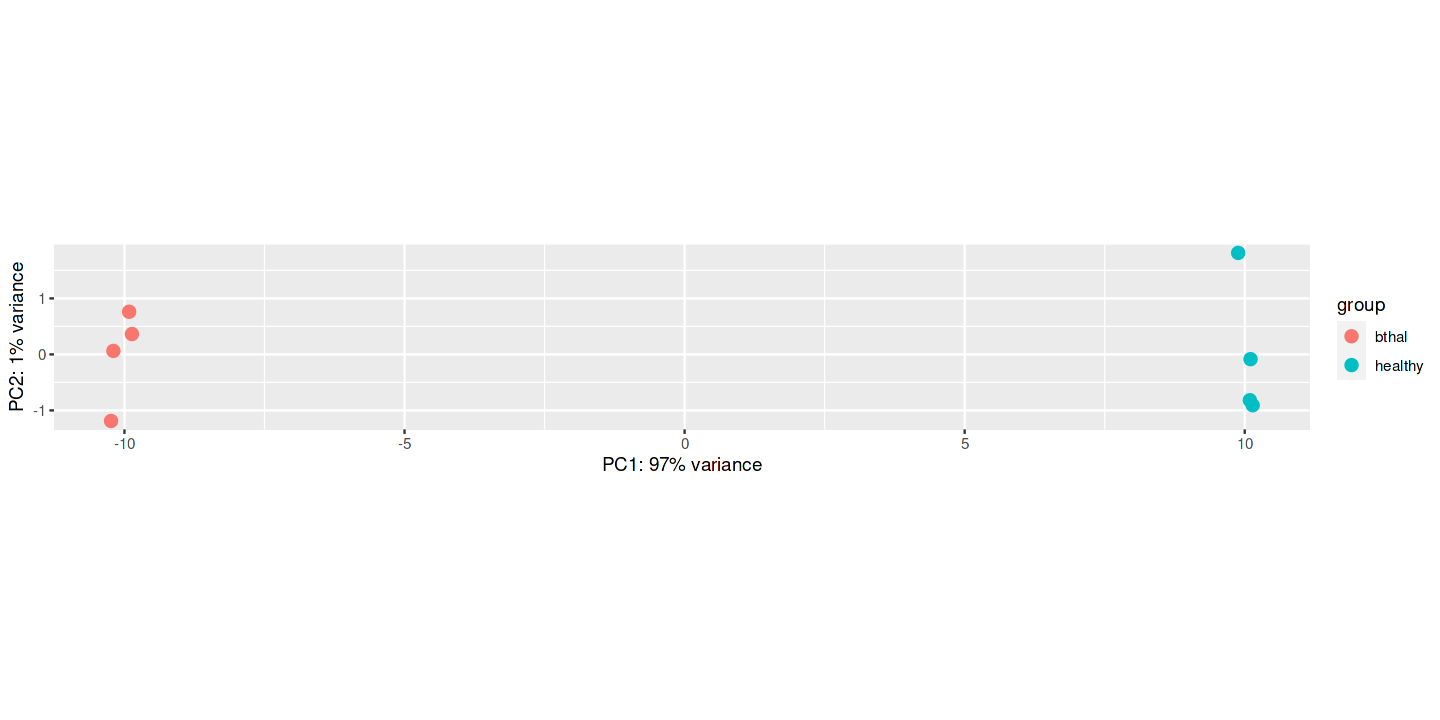

In [157]:
options(repr.plot.width = 12, repr.plot.height = 6)
# Plot PCA

DESeq2::plotPCA(rld, intgroup = "group_id")

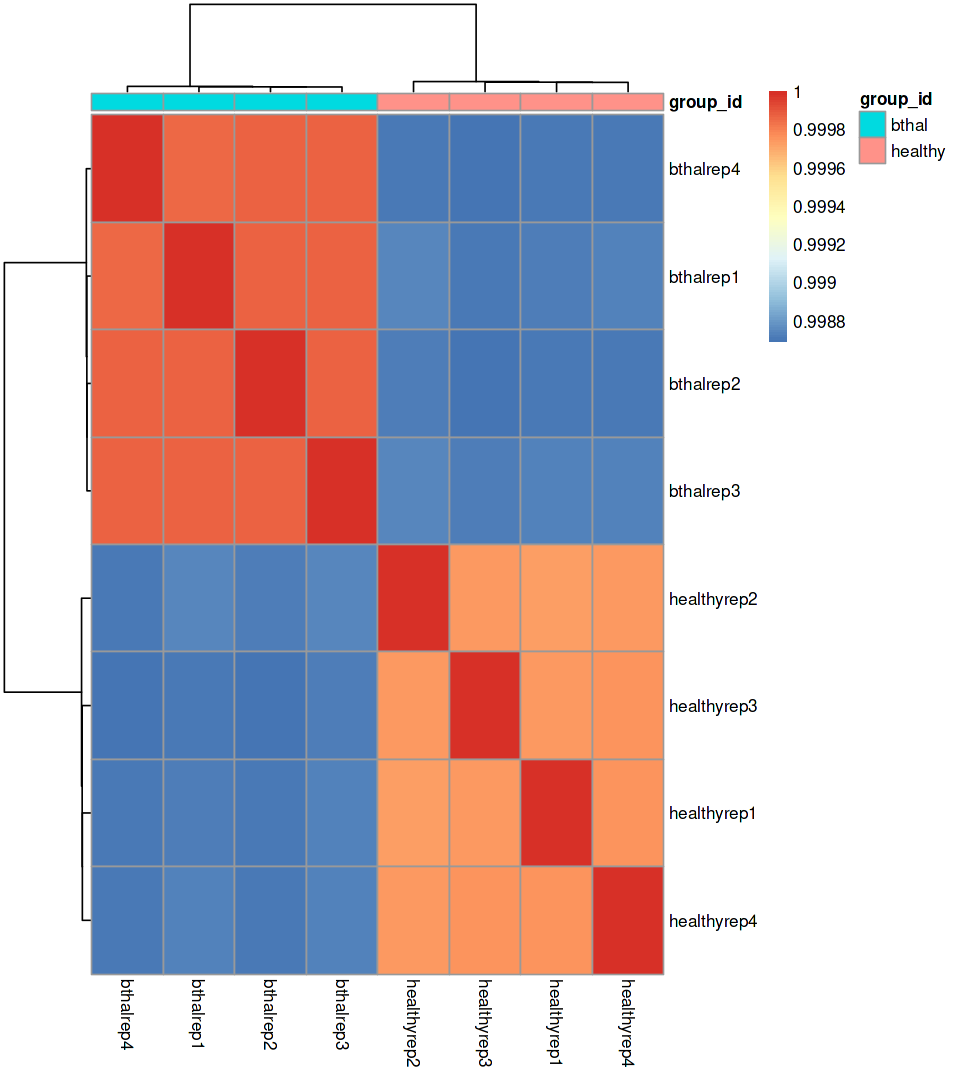

In [158]:
# Extract the rlog matrix from the object and compute pairwise correlation values
rld_mat <- assay(rld)
rld_cor <- cor(rld_mat)

options(repr.plot.width = 8, repr.plot.height = 9)
# Plot heatmap
pheatmap::pheatmap(rld_cor, annotation = cluster_metadata[, c("group_id"), drop=F])

In [160]:
# Run DESeq2 differential expression analysis
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



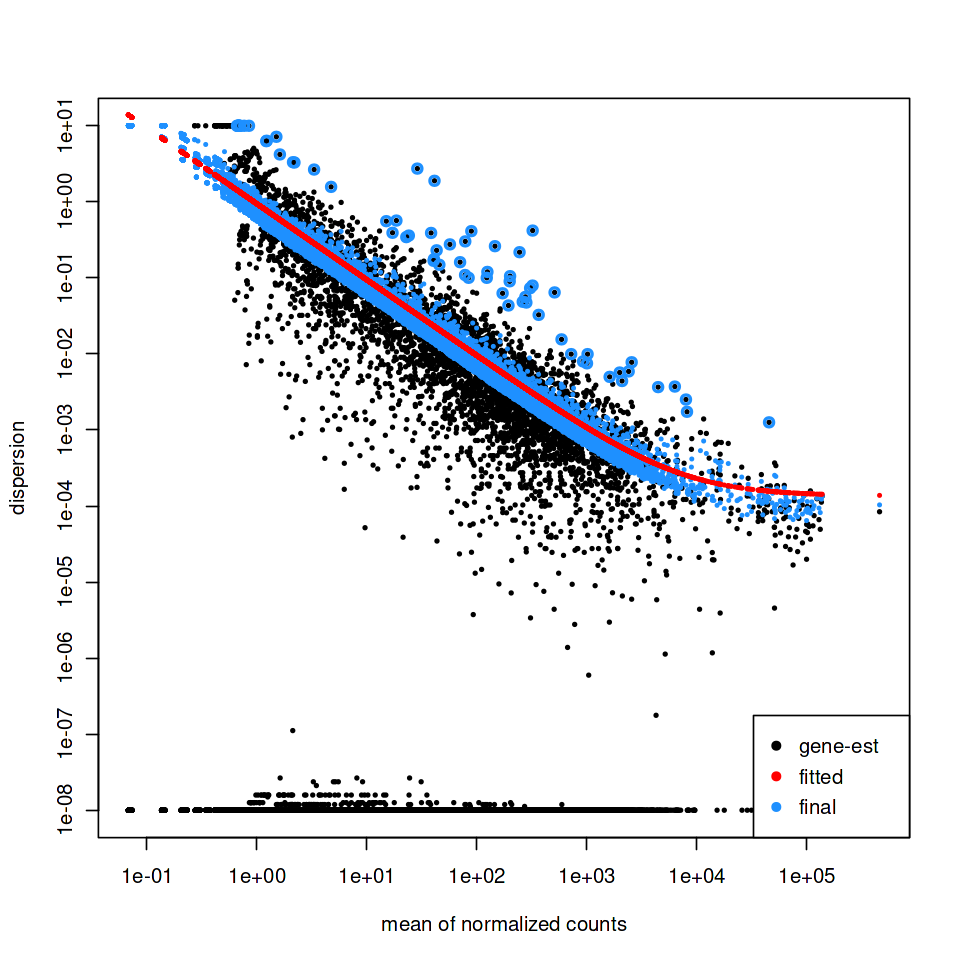

In [161]:
options(repr.plot.width = 8, repr.plot.height = 8)
# Plot dispersion estimates
plotDispEsts(dds)

In [163]:
levels(cluster_metadata$group_id)[1]

[1] "bthal"

In [164]:
basename <- 'bthalcombo_v6b'

In [165]:
# Output results of Wald test for contrast for bthal vs healthy ctrl
levels(cluster_metadata$group_id)[1]
levels(cluster_metadata$group_id)[2]

contrast <- c("group_id", levels(cluster_metadata$group_id)[1], levels(cluster_metadata$group_id)[2])

# resultsNames(dds)
res <- results(dds, 
               contrast = contrast,
               alpha = 0.05)


write.table(na.exclude( res[order(res$padj, res$pvalue), ] )['stat'], 
            file = paste0(resfolder, prefix, "_", basename, "_strict_", cluster, "_population_",
                          levels(cluster_metadata$group_id)[1], "_vs_", levels(cluster_metadata$group_id)[2], '.rnk'), 
            col.names = FALSE, quote = FALSE, sep='\t')


res <- lfcShrink(dds, 
                 contrast =  contrast,
                 type = "ashr",
                 res=res)

[1] "bthal"

[1] "healthy"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



In [166]:
# Turn the results object into a tibble for use with tidyverse functions
res_tbl <- res %>%
        data.frame() %>%
        tibble::rownames_to_column(var="gene") %>%
        tibble::as_tibble()

# Check results output
res_tbl

gene          baseMean     log2FoldChange lfcSE      pvalue        padj         
1     RP11-34P13.7    2.99155718 -0.015119181   0.28111206  8.731060e-01  9.329392e-01
2     AL627309.1     22.60077568 -1.227144537   0.32775885  2.522408e-06  2.257008e-05
3     AP006222.2     91.70598065 -0.033555573   0.11219241  6.974050e-01  8.242795e-01
4     RP4-669L17.10   7.35390445 -0.048325373   0.23290658  6.377485e-01  7.823921e-01
5     RP5-857K21.4    0.74407078 -0.032282160   0.37103926  6.899308e-01            NA
6     RP11-206L10.3  47.38577403 -0.152052407   0.15418887  1.439250e-01  2.946863e-01
7     RP11-206L10.5   0.58319449 -0.076262568   0.42498039  3.634093e-01            NA
8     RP11-206L10.4   1.69391513 -0.188540558   0.48309428  1.092059e-01            NA
9     RP11-206L10.2 109.58838919 -0.167582879   0.11563292  6.155752e-02  1.566482e-01
10    RP11-206L10.9  54.92169293  0.125676937   0.14761659  2.130814e-01  3.874942e-01
11    FAM87B          0.49082488  0.060814885   0.42684568  4.383804e-01            NA
12    LINC00115      42.67285724  0.006267249   0.14104277  9.480207e-01  9.722813e-01
13    FAM41C         50.31498864 -0.294792924   0.17927643  1.414777e-02  4.850070e-02
14    RP11-54O7.1     1.90095325 -0.299167354   0.58613327  4.399670e-02  1.204016e-01
15    RP11-54O7.2     0.22710652 -0.054179199   0.47501439  4.251261e-01            NA
16    RP11-54O7.3     0.07267561 -0.015588569   0.46114587  7.934079e-01            NA
17    SAMD11          2.46632043 -0.086319189   0.32363785  3.899462e-01  5.786441e-01
18    NOC2L         348.43964532 -0.007669467   0.06916003  9.007005e-01  9.472618e-01
19    KLHL17          1.64281441  0.266086804   0.60000811  5.277933e-02            NA
20    C1orf170        0.47965720  0.001794885   0.37983466  9.811923e-01            NA
21    HES4           20.07572452 -0.715063769   0.37346300  8.571150e-04  4.486294e-03
22    ISG15         854.02479443 -1.279604871   0.04887730 3.672874e-152 5.541278e-150
23    AGRN            4.71535116 -0.169730646   0.32575177  1.599468e-01  3.187238e-01
24    C1orf159       26.96764798  0.015483768   0.17082611  8.784968e-01  9.355704e-01
25    TTLL10-AS1      1.22841261 -0.017928696   0.32710770  8.371750e-01            NA
26    TTLL10         18.12501843  0.509027780   0.36666049  5.815968e-03  2.302366e-02
27    TNFRSF18        8.60925127 -0.634564134   0.50774337  4.572704e-03  1.883409e-02
28    TNFRSF4        24.53252635  0.762210096   0.35471907  4.228333e-04  2.396398e-03
29    SDF4          472.32399683  0.069880816   0.06055543  2.035592e-01  3.755427e-01
30    B3GALT6       130.51684377 -0.067955025   0.09900480  3.956081e-01  5.837745e-01
⋮     ⋮             ⋮            ⋮              ⋮          ⋮             ⋮            
20069 LSS           4.091658e+01 -0.18435526    0.16986562  9.434001e-02  2.171153e-01
20070 MCM3AP-AS1    1.610111e+02 -0.15898076    0.09750434  4.672600e-02  1.263447e-01
20071 MCM3AP        1.807163e+02  0.17234895    0.09780746  3.190823e-02  9.379293e-02
20072 AP001469.7    6.991518e-01  0.14298495    0.47883897  1.609131e-01            NA
20073 AP001469.9    1.998439e+01  0.01438636    0.18006404  8.877670e-01  9.400165e-01
20074 YBEY          3.000054e+02  0.03469876    0.07097657  5.799873e-01  7.423226e-01
20075 C21orf58      2.367949e+02  0.45908168    0.09658819  9.828140e-08  1.076208e-06
20076 PCNT          2.479730e+02  0.02709810    0.07876773  6.902535e-01  8.198506e-01
20077 DIP2A         3.011729e+02 -0.09330315    0.07321433  1.457901e-01  2.976449e-01
20078 S100B         9.127741e+00 -0.23479983    0.32633905  8.173407e-02  1.944197e-01
20079 PRMT2         8.062355e+02  0.34314201    0.05084570  1.561148e-12  2.683264e-11
20080 MT-ND1        2.562677e+04  0.10047139    0.01721054  3.703488e-09  4.744075e-08
20081 MT-ND2        2.875085e+04  0.23162437    0.01399485  4.718062e-62  3.447359e-60
20082 MT-CO1        6.246561e+04  0.09257379    0.01411650  4.033111e-11  6.270564e-10
2008

In [167]:
# Write all results to file
write.table(res_tbl,
          paste0(resfolder, prefix, "_", basename, "_strict_", cluster, "_population_",
                 levels(cluster_metadata$group_id)[1], "_vs_", levels(cluster_metadata$group_id)[2], 
                 "_all_genes_DESeq2_pb.tsv"),
          quote = FALSE, 
          row.names = FALSE,
          sep='\t')

In [168]:
# Set thresholds
padj_cutoff <- 0.05

# Subset the significant results
sig_res <- dplyr::filter(res_tbl, padj < padj_cutoff) %>%
        dplyr::arrange(padj)

# Check significant genes output
sig_res

gene          baseMean    log2FoldChange lfcSE       pvalue     padj      
1    IFI6            2700.2618 -2.3938248     0.034902251 0          0         
2    PDE4B           1546.9011 -1.5502264     0.041037206 0          0         
3    IFI44L          2105.9472 -2.4750223     0.035803495 0          0         
4    MCL1            4402.6345 -1.2083670     0.022493377 0          0         
5    ID2             2049.6785 -3.2859657     0.042399854 0          0         
6    ZFP36L2        14803.7912 -0.8687386     0.022062735 0          0         
7    RPS27A         70580.3449  0.4436190     0.009661298 0          0         
8    CXCR4           6639.7749 -3.6367823     0.027834617 0          0         
9    SDPR            4452.1645 -2.5634740     0.064563926 0          0         
10   STK17B          2926.4663 -1.1504583     0.030109904 0          0         
11   EEF1B2         31452.2072  0.7020005     0.011579215 0          0         
12   AREG            7974.4696 -4.6908376     0.056307581 0          0         
13   RPL34          99667.0284  0.6840834     0.009026359 0          0         
14   RPS3A         102168.3763  0.5888854     0.010530537 0          0         
15   CCNH            1887.8737 -2.3724712     0.036579078 0          0         
16   RPS14          65266.5014  0.7937176     0.012126959 0          0         
17   HLA-DRB5        3580.9090 -1.9002376     0.027108965 0          0         
18   EEF1A1        132726.3301  0.4979572     0.009775353 0          0         
19   RPS4X         101089.5841  1.2216722     0.011678640 0          0         
20   TSC22D3        11548.1371 -1.2988916     0.029058580 0          0         
21   SLA              881.9589 -2.1199495     0.050814379 0          0         
22   EEF1D           6151.2832  0.8930166     0.021167560 0          0         
23   NFIL3            914.3386 -2.7787742     0.056048034 0          0         
24   MAP3K8          1259.3805 -2.3133876     0.050079546 0          0         
25   SRGN           20583.5430 -2.5052871     0.014823000 0          0         
26   DDIT4           2091.8585 -3.6064814     0.075808973 0          0         
27   MALAT1        459477.7549 -0.3950112     0.010502524 0          0         
28   RPS3           79198.1491  0.5260209     0.009857550 0          0         
29   SLC2A3           561.8921 -4.0098498     0.082538989 0          0         
30   CD69            3805.0712 -3.0177598     0.031145809 0          0         
⋮    ⋮             ⋮           ⋮              ⋮           ⋮          ⋮         
4749 CTD-2260A17.2   89.430335  0.25284074    0.13896278  0.01408550 0.04832788
4750 AC009495.2       1.996066 -0.49530615    0.80452627  0.01409141 0.04833799
4751 HIST1H4A        41.864084  0.32534072    0.21455687  0.01410233 0.04836528
4752 UBE2Z          466.614532  0.14719903    0.06704221  0.01411678 0.04840464
4753 FAM41C          50.314989 -0.29479292    0.17927643  0.01414777 0.04850070
4754 SYT1            73.090046  0.28273838    0.16689879  0.01417103 0.04857022
4755 RINL           178.804563 -0.20015664    0.09914332  0.01420024 0.04866010
4756 CTC-425F1.4     62.662729 -0.28602171    0.17042440  0.01423005 0.04875198
4757 AC062029.1      44.925695 -0.30747571    0.19370500  0.01423778 0.04876822
4758 FOXN3-AS1       33.690883 -0.33283465    0.22513830  0.01426099 0.04883745
4759 AC016757.3      16.086838  0.41723668    0.36462728  0.01428572 0.04891185
4760 TTN-AS1        126.733876 -0.21867840    0.11237833  0.01433052 0.04905493
4761 CCDC169         12.224367  0.43755465    0.41025458  0.01435077 0.04911393
4762 RWDD2A          26.015708  0.36627244    0.27428502  0.01436045 0.04913673
4763 RP11-397A16.2    8.077572 -0.45564610    0.45841087  0.01438947 0.04922571
4764 FARP2           46.201322  0.33543509    0.22945746  0.01440157 0.04925675
4765 SCMH1          193.911194 -0.19372967    0.09515993  0.01440817 0.04926898
4766 THAP1          180.723812  0.20182179    0.10066886  0.01446910 0.04945658
4767 

In [169]:
# Write significant results to file
write.table(sig_res,
          paste0(resfolder, prefix, "_", basename, "_strict_", cluster, "_population_",
                 levels(cluster_metadata$group_id)[1], "_vs_", levels(cluster_metadata$group_id)[2],
                 "_sig_genes_DESeq2_pb.tsv"),
          quote = FALSE, 
          row.names = FALSE,
          sep='\t')

In [170]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/local/lib/R/lib/libRblas.so 
LAPACK: /usr/local/lib/R/lib/libRlapack.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C           LC_COLLATE=C       
 [5] LC_MONETARY=C       LC_MESSAGES=C       LC_PAPER=C          LC_NAME=C          
 [9] LC_ADDRESS=C        LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3          png_0.1-8                   pheatmap_1.0.12            
 [4] tibble_3.2.1                tidyr_1.3.1                 dplyr_1.1.4                
 [7] Matrix.utils_0.9.7          Matrix_1.6-5                DESeq2_1.42.0              
[10] scran_1.30.0                scater_1.30.1 

# END